In [5]:
# Cell 1: Install required packages
!pip install -q google-generativeai transformers pandas matplotlib seaborn tinydb

In [6]:

# Import all necessary libraries
import google.generativeai as genai
import json
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tinydb import TinyDB, Query
import time
import uuid
from functools import wraps
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [24]:
# Cell 2: Configure Gemini (FIXED)

from kaggle_secrets import UserSecretsClient
import google.generativeai as genai

# Try to get API key
try:
    user_secrets = UserSecretsClient()
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
    print("✅ API key loaded from Kaggle Secrets")
except Exception as e:
    print(f"⚠️ Could not load from Kaggle Secrets: {e}")
    GOOGLE_API_KEY = input("Please enter your Google API key: ").strip()

# Configure the API
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the model with safety settings
generation_config = {
    "temperature": 0.7,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 1024,
}

safety_settings = [
    {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"},
]

model = genai.GenerativeModel(
    model_name='gemini-2.5-flash',
    generation_config=generation_config,
    safety_settings=safety_settings
)

# Test the API connection
print("\n🔄 Testing Gemini API connection...")
try:
    test_response = model.generate_content("Say 'Hello, I am working!' in one short sentence.")
    print(f"✅ Gemini API working! Response: {test_response.text}")
except Exception as e:
    print(f"❌ Gemini API Error: {e}")
    print("\n⚠️ Please check:")
    print("   1. Your API key is correct")
    print("   2. The key is added to Kaggle Secrets as 'GOOGLE_API_KEY'")
    print("   3. You have enabled the Generative AI API in Google Cloud Console")

✅ API key loaded from Kaggle Secrets

🔄 Testing Gemini API connection...
✅ Gemini API working! Response: Hello, I'm working!


In [25]:
# Cell 3: Observability - Logging and Tracing System

class ObservabilitySystem:
    def __init__(self):
        self.logs = []
        self.traces = []
        self.metrics = {
            "total_conversations": 0,
            "avg_response_time": 0,
            "stress_scores": [],
            "agent_calls": {}
        }
    
    def log(self, agent_name, action, inputs, outputs):
        """Log agent activities"""
        log_entry = {
            "timestamp": datetime.now().isoformat(),
            "agent": agent_name,
            "action": action,
            "inputs": str(inputs)[:100],  # Truncate for readability
            "outputs": str(outputs)[:100]
        }
        self.logs.append(log_entry)
        print(f"📝 [{log_entry['timestamp'][:19]}] [{agent_name}] {action}")
    
    def trace(self, func):
        """Decorator for tracing function execution time"""
        @wraps(func)
        def wrapper(*args, **kwargs):
            start_time = time.time()
            result = func(*args, **kwargs)
            end_time = time.time()
            
            trace_entry = {
                "function": func.__name__,
                "duration": round(end_time - start_time, 3),
                "timestamp": datetime.now().isoformat()
            }
            self.traces.append(trace_entry)
            return result
        return wrapper
    
    def update_metrics(self, metric_name, value):
        """Update system metrics"""
        if metric_name == "response_time":
            times = [t["duration"] for t in self.traces]
            self.metrics["avg_response_time"] = sum(times) / len(times) if times else 0
        elif metric_name == "stress_score":
            self.metrics["stress_scores"].append(value)
        elif metric_name == "agent_call":
            self.metrics["agent_calls"][value] = self.metrics["agent_calls"].get(value, 0) + 1
    
    def get_metrics_summary(self):
        """Get summary of all metrics"""
        return {
            "total_logs": len(self.logs),
            "total_traces": len(self.traces),
            "avg_response_time": self.metrics["avg_response_time"],
            "avg_stress_score": sum(self.metrics["stress_scores"]) / len(self.metrics["stress_scores"]) if self.metrics["stress_scores"] else 0,
            "agent_calls": self.metrics["agent_calls"]
        }

# Initialize observability
obs = ObservabilitySystem()
print("✅ Observability system initialized!")

✅ Observability system initialized!


In [26]:
# Cell 4: Memory System - Short-term and Long-term Memory

class MemorySystem:
    def __init__(self, db_path="wellness_memory.json"):
        self.db = TinyDB(db_path)
        self.sessions_table = self.db.table('sessions')
        self.mood_table = self.db.table('moods')
        self.current_session = None
        self.short_term_memory = []  # Last 5 messages
        self.context_window = 5
    
    def create_session(self, student_id):
        """Create a new session for a student"""
        session_id = str(uuid.uuid4())[:8]
        session_data = {
            "session_id": session_id,
            "student_id": student_id,
            "start_time": datetime.now().isoformat(),
            "chat_history": [],
            "stress_scores": [],
            "mood_trend": [],
            "recommendations": []
        }
        self.sessions_table.insert(session_data)
        self.current_session = session_data
        obs.log("MemoryAgent", "create_session", student_id, session_id)
        return session_id
    
    def add_to_short_term(self, role, content):
        """Add message to short-term memory"""
        self.short_term_memory.append({"role": role, "content": content})
        if len(self.short_term_memory) > self.context_window:
            self.short_term_memory.pop(0)
    
    def save_mood(self, student_id, mood_data):
        """Save mood to long-term memory"""
        mood_entry = {
            "student_id": student_id,
            "timestamp": datetime.now().isoformat(),
            **mood_data
        }
        self.mood_table.insert(mood_entry)
        obs.log("MemoryAgent", "save_mood", student_id, mood_data.get("mood", "unknown"))
    
    def get_mood_history(self, student_id, limit=10):
        """Get mood history for a student"""
        Student = Query()
        moods = self.mood_table.search(Student.student_id == student_id)
        return moods[-limit:] if moods else []
    
    def compact_memory(self, student_id):
        """Compact long-term memory by summarizing old entries"""
        moods = self.get_mood_history(student_id, limit=100)
        if len(moods) > 20:
            # Keep only last 20 detailed entries, summarize the rest
            summary = {
                "type": "summary",
                "student_id": student_id,
                "period": f"{moods[0]['timestamp'][:10]} to {moods[-21]['timestamp'][:10]}",
                "avg_stress": sum(m.get("stress_score", 0) for m in moods[:-20]) / len(moods[:-20]),
                "dominant_mood": max(set(m.get("mood", "neutral") for m in moods[:-20]), 
                                    key=lambda x: sum(1 for m in moods[:-20] if m.get("mood") == x))
            }
            obs.log("MemoryAgent", "compact_memory", student_id, "Compacted old memories")
            return summary
        return None
    
    def get_context(self):
        """Get current conversation context"""
        return self.short_term_memory.copy()

# Initialize memory system
memory = MemorySystem()
print("✅ Memory system initialized!")

✅ Memory system initialized!


In [27]:
# Cell 5: Custom Tools

class WellnessTools:
    def __init__(self, memory_system, observability):
        self.memory = memory_system
        self.obs = observability
    
    # Tool 1: Mood Logging Tool
    def log_mood(self, student_id, mood, stress_score, comment=""):
        """Log mood data for a student"""
        mood_data = {
            "mood": mood,
            "stress_score": stress_score,
            "comment": comment,
            "timestamp": datetime.now().isoformat()
        }
        self.memory.save_mood(student_id, mood_data)
        self.obs.update_metrics("stress_score", stress_score)
        self.obs.log("MoodLoggingTool", "log_mood", student_id, mood_data)
        return mood_data
    
    # Tool 2: Wellness Insight Graph Tool
    def generate_mood_graph(self, student_id):
        """Generate visualization of mood trends"""
        moods = self.memory.get_mood_history(student_id, limit=30)
        
        if not moods:
            print("No mood data available yet.")
            return None
        
        # Prepare data
        df = pd.DataFrame(moods)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Mental Wellness Dashboard - Student: {student_id}', fontsize=14, fontweight='bold')
        
        # Plot 1: Stress Score Over Time
        axes[0, 0].plot(df['timestamp'], df['stress_score'], marker='o', color='coral', linewidth=2)
        axes[0, 0].fill_between(df['timestamp'], df['stress_score'], alpha=0.3, color='coral')
        axes[0, 0].set_title('Stress Level Over Time')
        axes[0, 0].set_ylabel('Stress Score')
        axes[0, 0].set_ylim(0, 1)
        axes[0, 0].axhline(y=0.7, color='red', linestyle='--', label='High Stress Threshold')
        axes[0, 0].legend()
        
        # Plot 2: Mood Distribution
        mood_counts = df['mood'].value_counts()
        colors = {'stressed': '#ff6b6b', 'anxious': '#ffa502', 'neutral': '#74b9ff', 
                  'happy': '#26de81', 'sad': '#a55eea', 'calm': '#20bf6b'}
        bar_colors = [colors.get(m, '#95a5a6') for m in mood_counts.index]
        axes[0, 1].bar(mood_counts.index, mood_counts.values, color=bar_colors)
        axes[0, 1].set_title('Mood Distribution')
        axes[0, 1].set_ylabel('Count')
        
        # Plot 3: Weekly Average Stress
        df['day'] = df['timestamp'].dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_stress = df.groupby('day')['stress_score'].mean().reindex(day_order).dropna()
        axes[1, 0].bar(daily_stress.index, daily_stress.values, color='mediumpurple')
        axes[1, 0].set_title('Average Stress by Day')
        axes[1, 0].set_ylabel('Avg Stress Score')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Plot 4: Stress Trend with Moving Average
        if len(df) >= 3:
            df['stress_ma'] = df['stress_score'].rolling(window=3, min_periods=1).mean()
            axes[1, 1].plot(df['timestamp'], df['stress_score'], 'o-', alpha=0.5, label='Actual')
            axes[1, 1].plot(df['timestamp'], df['stress_ma'], '-', linewidth=2, color='green', label='3-Point Moving Avg')
            axes[1, 1].set_title('Stress Trend Analysis')
            axes[1, 1].legend()
        else:
            axes[1, 1].text(0.5, 0.5, 'Need more data for trend analysis', ha='center', va='center')
            axes[1, 1].set_title('Stress Trend Analysis')
        
        plt.tight_layout()
        plt.savefig(f'wellness_dashboard_{student_id}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        self.obs.log("GraphTool", "generate_mood_graph", student_id, "Dashboard generated")
        return fig
    
    # Tool 3: Personalized Recommendation Tool
    def get_recommendations(self, stress_level, mood):
        """Get personalized wellness recommendations"""
        recommendations = {
            "high_stress": [
                "🧘 Try the 4-7-8 breathing technique: Inhale for 4 seconds, hold for 7, exhale for 8",
                "🚶 Take a 10-minute walk outside",
                "📝 Write down 3 things you're grateful for",
                "🎵 Listen to calming music for 5 minutes",
                "💤 Consider a 20-minute power nap if possible"
            ],
            "medium_stress": [
                "☕ Take a short break and stretch",
                "🌿 Practice mindful breathing for 2 minutes",
                "📱 Step away from screens for 10 minutes",
                "💬 Talk to a friend or family member"
            ],
            "low_stress": [
                "⭐ Great job managing your stress!",
                "📚 This is a good time for focused study",
                "🎯 Set a small goal for today",
                "😊 Share positivity with someone"
            ]
        }
        
        mood_tips = {
            "anxious": "Remember: This feeling is temporary. Focus on what you can control right now.",
            "sad": "It's okay to feel sad. Consider reaching out to someone you trust.",
            "stressed": "Break your tasks into smaller steps. One thing at a time.",
            "happy": "Wonderful! Consider journaling about what's making you happy.",
            "neutral": "A good baseline! What would make today even better?"
        }
        
        if stress_level > 0.7:
            level = "high_stress"
        elif stress_level > 0.4:
            level = "medium_stress"
        else:
            level = "low_stress"
        
        result = {
            "stress_recommendations": recommendations[level],
            "mood_tip": mood_tips.get(mood, "Take care of yourself today!"),
            "stress_level_category": level
        }
        
        self.obs.log("RecommendationTool", "get_recommendations", f"{mood}/{stress_level}", level)
        return result

# Initialize tools
tools = WellnessTools(memory, obs)
print("✅ Wellness tools initialized!")

✅ Wellness tools initialized!


In [28]:
# Cell 6: Sentiment & Stress Analyzer Agent

class StressAnalyzerAgent:
    def __init__(self, observability):
        self.obs = observability
        # Load sentiment analysis pipeline
        print("Loading sentiment analysis model...")
        self.sentiment_analyzer = pipeline(
            "sentiment-analysis", 
            model="distilbert-base-uncased-finetuned-sst-2-english"
        )
        # Load zero-shot classifier for emotion detection
        print("Loading emotion classifier...")
        self.emotion_classifier = pipeline(
            "zero-shot-classification",
            model="facebook/bart-large-mnli"
        )
        self.emotion_labels = ["happy", "sad", "anxious", "stressed", "calm", "neutral", "angry", "overwhelmed"]
        print("✅ Stress Analyzer Agent ready!")
    
    @obs.trace
    def analyze_sentiment(self, text):
        """Analyze sentiment polarity"""
        result = self.sentiment_analyzer(text)[0]
        return {
            "label": result["label"],
            "score": round(result["score"], 3)
        }
    
    @obs.trace
    def detect_emotion(self, text):
        """Detect specific emotion"""
        result = self.emotion_classifier(text, self.emotion_labels)
        top_emotion = result["labels"][0]
        confidence = round(result["scores"][0], 3)
        return {
            "emotion": top_emotion,
            "confidence": confidence,
            "all_scores": dict(zip(result["labels"][:3], [round(s, 3) for s in result["scores"][:3]]))
        }
    
    @obs.trace  
    def calculate_stress_score(self, text, sentiment, emotion):
        """Calculate overall stress score (0-1)"""
        stress_keywords = ["overwhelmed", "exhausted", "stressed", "anxious", "worried", 
                         "can't sleep", "too much", "failing", "pressure", "deadline",
                         "exam", "burnout", "tired", "panic", "hopeless"]
        
        # Base score from sentiment
        if sentiment["label"] == "NEGATIVE":
            base_score = 0.5 + (sentiment["score"] * 0.3)
        else:
            base_score = 0.3 - (sentiment["score"] * 0.2)
        
        # Adjust based on emotion
        emotion_weights = {
            "stressed": 0.3, "anxious": 0.25, "overwhelmed": 0.35,
            "angry": 0.2, "sad": 0.15, "neutral": 0, "calm": -0.2, "happy": -0.25
        }
        emotion_adjustment = emotion_weights.get(emotion["emotion"], 0)
        
        # Keyword bonus
        keyword_count = sum(1 for kw in stress_keywords if kw in text.lower())
        keyword_bonus = min(keyword_count * 0.05, 0.2)
        
        # Final score
        stress_score = max(0, min(1, base_score + emotion_adjustment + keyword_bonus))
        
        return round(stress_score, 3)
    
    def get_stress_level(self, score):
        """Convert score to category"""
        if score >= 0.7:
            return "high"
        elif score >= 0.4:
            return "medium"
        return "low"
    
    @obs.trace
    def full_analysis(self, text):
        """Perform complete stress analysis"""
        sentiment = self.analyze_sentiment(text)
        emotion = self.detect_emotion(text)
        stress_score = self.calculate_stress_score(text, sentiment, emotion)
        stress_level = self.get_stress_level(stress_score)
        
        result = {
            "sentiment": sentiment,
            "emotion": emotion,
            "stress_score": stress_score,
            "stress_level": stress_level,
            "burnout_risk": "HIGH" if stress_score > 0.8 else "MODERATE" if stress_score > 0.6 else "LOW"
        }
        
        self.obs.log("StressAnalyzer", "full_analysis", text[:50], result)
        self.obs.update_metrics("agent_call", "StressAnalyzer")
        
        return result

# Initialize stress analyzer
stress_analyzer = StressAnalyzerAgent(obs)

Loading sentiment analysis model...


Device set to use cpu


Loading emotion classifier...


Device set to use cpu


✅ Stress Analyzer Agent ready!


In [29]:
# Cell 7: Chat Support Agent (FIXED - Better error handling)

class ChatSupportAgent:
    def __init__(self, model, memory_system, stress_analyzer, tools, observability):
        self.model = model
        self.memory = memory_system
        self.stress_analyzer = stress_analyzer
        self.tools = tools
        self.obs = observability
        
        self.system_prompt = """You are a compassionate AI Mental Wellness Companion for students. 
Your role is to:
1. Provide emotional support and active listening
2. Offer evidence-based coping strategies
3. Give mindfulness and relaxation tips
4. Help students manage academic stress
5. Encourage healthy habits

Guidelines:
- Be warm, empathetic, and non-judgmental
- Use supportive language
- Ask follow-up questions to understand better
- Provide actionable suggestions
- If someone seems in crisis, gently encourage professional help
- Keep responses concise but meaningful (2-4 sentences)

Current context about the student will be provided. Use it to personalize your response."""

    def generate_response(self, user_message, student_id, stress_analysis=None, context=None):
        """Generate supportive response"""
        
        # Build context
        context_str = ""
        if stress_analysis:
            context_str += f"\n[Student's current state: Stress Level={stress_analysis['stress_level']}, "
            context_str += f"Emotion={stress_analysis['emotion']['emotion']}, "
            context_str += f"Burnout Risk={stress_analysis['burnout_risk']}]"
        
        if context:
            recent_messages = "\n".join([f"{m['role']}: {m['content']}" for m in context[-3:]])
            context_str += f"\n[Recent conversation:\n{recent_messages}]"
        
        # Get mood history summary
        mood_history = self.memory.get_mood_history(student_id, limit=5)
        if mood_history:
            recent_moods = [m.get("mood", "unknown") for m in mood_history]
            context_str += f"\n[Recent mood pattern: {', '.join(recent_moods)}]"
        
        # Create prompt
        full_prompt = f"""{self.system_prompt}

{context_str}

Student's message: {user_message}

Respond with empathy and provide helpful support (2-4 sentences):"""

        try:
            response = self.model.generate_content(full_prompt)
            
            # Check if response has text
            if response and response.text:
                assistant_message = response.text.strip()
            elif response and response.parts:
                assistant_message = response.parts[0].text.strip()
            else:
                # Check for blocked content
                if response.prompt_feedback:
                    self.obs.log("ChatAgent", "blocked", str(response.prompt_feedback), "Content blocked")
                assistant_message = self._get_contextual_fallback(stress_analysis)
                
        except Exception as e:
            error_msg = str(e)
            self.obs.log("ChatAgent", "error", error_msg[:100], "Used fallback response")
            print(f"   ⚠️ API Error: {error_msg[:80]}...")
            assistant_message = self._get_contextual_fallback(stress_analysis)
        
        # Update memory
        self.memory.add_to_short_term("user", user_message)
        self.memory.add_to_short_term("assistant", assistant_message)
        
        self.obs.log("ChatAgent", "generate_response", user_message[:50], assistant_message[:50])
        self.obs.update_metrics("agent_call", "ChatAgent")
        
        return assistant_message
    
    def _get_contextual_fallback(self, stress_analysis):
        """Get a contextual fallback response based on stress analysis"""
        if not stress_analysis:
            return "I'm here to support you. Could you tell me more about how you're feeling?"
        
        stress_level = stress_analysis.get('stress_level', 'medium')
        emotion = stress_analysis.get('emotion', {}).get('emotion', 'neutral')
        
        fallback_responses = {
            ('high', 'stressed'): "I can hear that you're going through a really tough time right now. It's completely understandable to feel overwhelmed. Remember, it's okay to take things one step at a time. What feels like the most pressing concern right now?",
            ('high', 'anxious'): "Anxiety can feel so overwhelming, especially during stressful periods. Your feelings are valid. Have you tried any deep breathing exercises? Sometimes just a few minutes can help calm the mind.",
            ('high', 'overwhelmed'): "It sounds like you have a lot on your plate right now. That's genuinely hard. Let's try to break things down into smaller, manageable pieces. What's one small thing you could focus on first?",
            ('high', 'sad'): "I'm sorry you're feeling this way. It takes courage to share these feelings. Remember, it's okay to not be okay sometimes. Is there someone you trust that you could talk to about this?",
            ('medium', 'stressed'): "It sounds like things are a bit challenging right now. That's completely normal, especially as a student. What's been weighing on you the most?",
            ('medium', 'anxious'): "Some worry is natural, and it shows you care. Let's work through this together. What specific thing is making you feel anxious?",
            ('low', 'calm'): "It's great to hear you're feeling more settled. Maintaining this balance is important. What's been helping you feel this way?",
            ('low', 'happy'): "That's wonderful to hear! It's so important to acknowledge and celebrate these positive moments. What contributed to your good mood today?",
        }
        
        # Try to find matching response
        key = (stress_level, emotion)
        if key in fallback_responses:
            return fallback_responses[key]
        
        # Generic fallbacks by stress level
        if stress_level == 'high':
            return "I can sense you're going through a difficult time. Your feelings are completely valid. I'm here to listen and support you. Would you like to share more about what's on your mind?"
        elif stress_level == 'medium':
            return "Thank you for sharing that with me. It sounds like you're dealing with some challenges. Let's work through this together. What would be most helpful to focus on?"
        else:
            return "Thanks for sharing! It sounds like things are going reasonably well. Is there anything specific you'd like to talk about or any goals you're working towards?"
    
    def summarize_conversation(self):
        """Summarize the current conversation"""
        context = self.memory.get_context()
        if not context:
            return "No conversation to summarize yet."
        
        conversation_text = "\n".join([f"{m['role']}: {m['content']}" for m in context])
        
        prompt = f"""Summarize this mental wellness conversation in 2-3 sentences, 
highlighting key emotions and concerns:

{conversation_text}

Summary:"""
        
        try:
            response = self.model.generate_content(prompt)
            if response and response.text:
                summary = response.text.strip()
            else:
                summary = self._generate_fallback_summary(context)
        except Exception as e:
            self.obs.log("ChatAgent", "summary_error", str(e)[:50], "Used fallback summary")
            summary = self._generate_fallback_summary(context)
        
        self.obs.log("ChatAgent", "summarize_conversation", "Full context", summary[:100])
        return summary
    
    def _generate_fallback_summary(self, context):
        """Generate a basic summary without API"""
        if not context:
            return "No conversation recorded."
        
        user_messages = [m['content'] for m in context if m['role'] == 'user']
        if not user_messages:
            return "Session started but no user messages recorded."
        
        # Simple keyword-based summary
        keywords = {
            'stress': ['stressed', 'stress', 'overwhelming', 'overwhelmed', 'pressure'],
            'sleep': ['sleep', 'sleeping', 'tired', 'exhausted', 'insomnia'],
            'academic': ['exam', 'exams', 'study', 'studying', 'assignment', 'class', 'classes'],
            'anxiety': ['anxious', 'anxiety', 'worried', 'worry', 'nervous'],
            'positive': ['better', 'good', 'okay', 'fine', 'happy', 'finished', 'completed']
        }
        
        detected_themes = []
        all_text = ' '.join(user_messages).lower()
        
        for theme, words in keywords.items():
            if any(word in all_text for word in words):
                detected_themes.append(theme)
        
        if detected_themes:
            themes_str = ', '.join(detected_themes)
            return f"During this session, the student discussed topics related to: {themes_str}. The conversation covered {len(user_messages)} messages exploring their current wellbeing and concerns."
        else:
            return f"The student engaged in {len(user_messages)} exchanges discussing their current state and seeking support."

# Re-initialize chat agent with fixed version
chat_agent = ChatSupportAgent(model, memory, stress_analyzer, tools, obs)
print("✅ Chat Support Agent initialized (with improved error handling)!")

✅ Chat Support Agent initialized (with improved error handling)!


In [30]:
# Cell 8: Personalized Study Plan Agent (FIXED)

class StudyPlanAgent:
    def __init__(self, model, observability):
        self.model = model
        self.obs = observability
    
    def generate_study_plan(self, stress_level, mood, subjects, hours_available):
        """Generate personalized study plan based on mental state"""
        
        # Adjust plan based on stress level
        if stress_level == "high":
            study_intensity = "light"
            break_frequency = "every 20 minutes"
            focus_duration = 20
            break_duration = 10
        elif stress_level == "medium":
            study_intensity = "moderate"
            break_frequency = "every 35 minutes"
            focus_duration = 35
            break_duration = 7
        else:
            study_intensity = "normal"
            break_frequency = "every 50 minutes"
            focus_duration = 50
            break_duration = 5
        
        prompt = f"""Create a personalized study schedule for a student with the following conditions:
- Current stress level: {stress_level}
- Current mood: {mood}
- Subjects to study: {', '.join(subjects)}
- Hours available: {hours_available}
- Recommended study intensity: {study_intensity}
- Break frequency: {break_frequency}
- Focus duration per session: {focus_duration} minutes

Create a structured schedule that:
1. Prioritizes subjects based on typical difficulty
2. Includes specific break activities (stretching, breathing, snack)
3. Matches energy-intensive subjects with peak hours
4. Includes a wind-down period

Format as a clear, time-blocked schedule with emojis."""

        try:
            response = self.model.generate_content(prompt)
            if response and response.text:
                plan = response.text.strip()
            else:
                plan = self._generate_detailed_fallback_plan(subjects, hours_available, focus_duration, break_duration, stress_level)
        except Exception as e:
            self.obs.log("StudyPlanAgent", "error", str(e)[:50], "Used fallback plan")
            plan = self._generate_detailed_fallback_plan(subjects, hours_available, focus_duration, break_duration, stress_level)
        
        self.obs.log("StudyPlanAgent", "generate_plan", f"{stress_level}/{mood}", "Plan generated")
        self.obs.update_metrics("agent_call", "StudyPlanAgent")
        
        return plan
    
    def _generate_detailed_fallback_plan(self, subjects, hours, focus_duration, break_duration, stress_level):
        """Generate a detailed fallback plan without API"""
        
        # Calculate sessions
        total_minutes = hours * 60
        session_length = focus_duration + break_duration
        num_sessions = total_minutes // session_length
        
        # Break activities
        break_activities = [
            "🚶 Take a short walk",
            "🧘 Do stretching exercises", 
            "💧 Drink water & have a healthy snack",
            "🎵 Listen to calming music",
            "👁️ Rest your eyes - look at something distant",
            "🌬️ Practice deep breathing (4-7-8 technique)"
        ]
        
        plan = f"""
📚 **PERSONALIZED STUDY PLAN**
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 **Your Status:**
   • Stress Level: {stress_level.upper()}
   • Focus Duration: {focus_duration} minutes
   • Break Duration: {break_duration} minutes
   • Total Study Time: {hours} hours

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏰ **SCHEDULE:**
"""
        
        current_hour = 9
        current_minute = 0
        
        for i in range(min(num_sessions, len(subjects) * 2)):
            subject = subjects[i % len(subjects)]
            break_activity = break_activities[i % len(break_activities)]
            
            # Study session
            start_time = f"{current_hour:02d}:{current_minute:02d}"
            current_minute += focus_duration
            if current_minute >= 60:
                current_hour += current_minute // 60
                current_minute = current_minute % 60
            end_time = f"{current_hour:02d}:{current_minute:02d}"
            
            plan += f"""
📖 **{start_time} - {end_time}** | {subject}
   └─ Focus: {focus_duration} min of concentrated study
"""
            
            # Break
            break_start = end_time
            current_minute += break_duration
            if current_minute >= 60:
                current_hour += current_minute // 60
                current_minute = current_minute % 60
            break_end = f"{current_hour:02d}:{current_minute:02d}"
            
            plan += f"""
☕ **{break_start} - {break_end}** | BREAK
   └─ {break_activity}
"""
        
        # Add tips based on stress level
        if stress_level == "high":
            tips = """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 **WELLNESS TIPS (High Stress Mode):**
   • It's okay to take longer breaks if needed
   • Focus on understanding, not perfection
   • Celebrate small wins after each session
   • If feeling overwhelmed, pause and breathe
   • Consider reducing study load if needed
"""
        elif stress_level == "medium":
            tips = """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 **WELLNESS TIPS (Moderate Pace):**
   • Stay hydrated throughout your study session
   • Use the Pomodoro technique for focus
   • Review notes at the end of each session
   • Take proper breaks - don't skip them!
"""
        else:
            tips = """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 **PRODUCTIVITY TIPS:**
   • Great energy! Tackle difficult topics first
   • Set specific goals for each session
   • Test yourself with practice problems
   • End with a quick review of what you learned
"""
        
        plan += tips
        plan += """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🌟 Remember: Progress over perfection! 🌟
"""
        
        return plan

# Re-initialize study plan agent
study_plan_agent = StudyPlanAgent(model, obs)
print("✅ Study Plan Agent initialized (with detailed fallback)!")

✅ Study Plan Agent initialized (with detailed fallback)!


In [31]:
# Cell 9: Quiz & Feedback Agent

class QuizReflectionAgent:
    def __init__(self, model, observability):
        self.model = model
        self.obs = observability
        
        self.reflection_questions = [
            "On a scale of 1-10, how would you rate your energy level today?",
            "What's one thing that went well for you today?",
            "What's causing you the most stress right now?",
            "Did you get enough sleep last night?",
            "Have you taken any breaks today?",
            "What's one small thing you could do right now to feel better?",
            "How connected do you feel to friends/family this week?",
            "Are you drinking enough water today?"
        ]
        
        self.wellness_quiz = [
            {
                "question": "How often have you felt overwhelmed in the past week?",
                "options": ["Never", "Once or twice", "Several times", "Almost every day"],
                "scores": [0, 1, 2, 3]
            },
            {
                "question": "How would you rate your sleep quality?",
                "options": ["Excellent", "Good", "Fair", "Poor"],
                "scores": [0, 1, 2, 3]
            },
            {
                "question": "How often do you take breaks while studying?",
                "options": ["Regularly", "Sometimes", "Rarely", "Never"],
                "scores": [0, 1, 2, 3]
            },
            {
                "question": "How would you describe your current workload?",
                "options": ["Manageable", "Slightly heavy", "Heavy", "Overwhelming"],
                "scores": [0, 1, 2, 3]
            }
        ]
    
    def get_reflection_question(self):
        """Get a random reflection question"""
        import random
        question = random.choice(self.reflection_questions)
        self.obs.log("QuizAgent", "get_reflection", "random", question)
        return question
    
    def run_wellness_check(self):
        """Run interactive wellness quiz"""
        print("\n🎯 WELLNESS CHECK-IN\n" + "="*40)
        total_score = 0
        
        for i, q in enumerate(self.wellness_quiz, 1):
            print(f"\n{i}. {q['question']}")
            for j, opt in enumerate(q['options'], 1):
                print(f"   {j}. {opt}")
            
            while True:
                try:
                    choice = int(input("Your choice (1-4): ")) - 1
                    if 0 <= choice <= 3:
                        total_score += q['scores'][choice]
                        break
                except:
                    print("Please enter a number 1-4")
        
        # Calculate wellness score
        max_score = len(self.wellness_quiz) * 3
        wellness_percentage = 100 - (total_score / max_score * 100)
        
        result = {
            "raw_score": total_score,
            "wellness_percentage": round(wellness_percentage, 1),
            "status": self._get_wellness_status(wellness_percentage)
        }
        
        print(f"\n📊 Your Wellness Score: {result['wellness_percentage']}%")
        print(f"Status: {result['status']}")
        
        self.obs.log("QuizAgent", "wellness_check", total_score, result)
        self.obs.update_metrics("agent_call", "QuizAgent")
        
        return result
    
    def _get_wellness_status(self, percentage):
        if percentage >= 80:
            return "🌟 Excellent! You're managing well."
        elif percentage >= 60:
            return "👍 Good, but there's room for improvement."
        elif percentage >= 40:
            return "⚠️ Moderate stress detected. Consider some self-care."
        else:
            return "🆘 High stress levels. Please prioritize your wellbeing."

# Initialize quiz agent
quiz_agent = QuizReflectionAgent(model, obs)
print("✅ Quiz & Reflection Agent initialized!")

✅ Quiz & Reflection Agent initialized!


In [32]:
# Cell 10 (continued): Alert/Guardian Agent

class AlertGuardianAgent:
    def __init__(self, memory_system, observability):
        self.memory = memory_system
        self.obs = observability
        self.alert_thresholds = {
            "stress_spike": 0.75,
            "burnout_risk": 0.8,
            "mood_drop_threshold": 3,
            "late_night_hours": (23, 5)
        }
        self.alerts = []
    
    def check_alerts(self, student_id, current_stress=None, current_mood=None):
        """Check for alert conditions"""
        alerts_triggered = []
        
        mood_history = self.memory.get_mood_history(student_id, limit=10)
        
        if not mood_history:
            return alerts_triggered
        
        # Check 1: Sudden stress spike
        if current_stress and current_stress > self.alert_thresholds["stress_spike"]:
            alerts_triggered.append({
                "type": "STRESS_SPIKE",
                "severity": "HIGH",
                "message": f"⚠️ High stress detected (Score: {current_stress:.2f}). Consider taking a break.",
                "timestamp": datetime.now().isoformat()
            })
        
        # Check 2: Burnout risk
        if len(mood_history) >= 5:
            recent_scores = [m.get("stress_score", 0) for m in mood_history[-5:]]
            avg_recent_stress = sum(recent_scores) / len(recent_scores)
            if avg_recent_stress > self.alert_thresholds["burnout_risk"]:
                alerts_triggered.append({
                    "type": "BURNOUT_RISK",
                    "severity": "CRITICAL",
                    "message": "🔴 BURNOUT RISK: Consistently high stress levels detected. Please prioritize rest.",
                    "timestamp": datetime.now().isoformat()
                })
        
        # Check 3: Mood drop pattern
        negative_moods = ["stressed", "anxious", "sad", "overwhelmed", "angry"]
        recent_moods = [m.get("mood", "neutral") for m in mood_history[-3:]]
        if all(mood in negative_moods for mood in recent_moods):
            alerts_triggered.append({
                "type": "MOOD_DROP",
                "severity": "MEDIUM",
                "message": "📉 Consecutive negative moods detected. Would you like to talk about what's bothering you?",
                "timestamp": datetime.now().isoformat()
            })
        
        # Check 4: Late night activity
        current_hour = datetime.now().hour
        start, end = self.alert_thresholds["late_night_hours"]
        if current_hour >= start or current_hour < end:
            alerts_triggered.append({
                "type": "LATE_NIGHT",
                "severity": "LOW",
                "message": "🌙 Late night detected. Good sleep is essential for mental wellness and academic performance.",
                "timestamp": datetime.now().isoformat()
            })
        
        # Check 5: Stress trend analysis
        if len(mood_history) >= 7:
            week_scores = [m.get("stress_score", 0) for m in mood_history[-7:]]
            first_half = sum(week_scores[:3]) / 3
            second_half = sum(week_scores[-3:]) / 3
            if second_half > first_half + 0.2:
                alerts_triggered.append({
                    "type": "INCREASING_TREND",
                    "severity": "MEDIUM",
                    "message": "📈 Your stress levels have been increasing. Let's work on some coping strategies.",
                    "timestamp": datetime.now().isoformat()
                })
        
        # Store and log alerts
        for alert in alerts_triggered:
            self.alerts.append(alert)
            self.obs.log("AlertAgent", alert["type"], alert["severity"], alert["message"][:50])
        
        self.obs.update_metrics("agent_call", "AlertAgent")
        return alerts_triggered
    
    def get_alert_summary(self):
        """Get summary of all alerts"""
        if not self.alerts:
            return "✅ No alerts at this time."
        
        summary = "🚨 ALERT SUMMARY\n" + "="*40 + "\n"
        for alert in self.alerts[-5:]:
            summary += f"\n[{alert['severity']}] {alert['type']}\n{alert['message']}\n"
        return summary
    
    def clear_alerts(self):
        """Clear all alerts"""
        self.alerts = []
        self.obs.log("AlertAgent", "clear_alerts", "all", "Alerts cleared")

# Initialize alert agent
alert_agent = AlertGuardianAgent(memory, obs)
print("✅ Alert/Guardian Agent initialized!")

✅ Alert/Guardian Agent initialized!


In [33]:
# Cell 11: Main Orchestrator - Coordinates all agents

class WellnessOrchestrator:
    def __init__(self):
        self.chat_agent = chat_agent
        self.stress_analyzer = stress_analyzer
        self.study_plan_agent = study_plan_agent
        self.quiz_agent = quiz_agent
        self.alert_agent = alert_agent
        self.memory = memory
        self.tools = tools
        self.obs = obs
        self.current_student = None
    
    def start_session(self, student_id):
        """Start a new wellness session"""
        session_id = self.memory.create_session(student_id)
        self.current_student = student_id
        print(f"\n{'='*50}")
        print(f"🌟 WELLNESS SESSION STARTED")
        print(f"📋 Session ID: {session_id}")
        print(f"👤 Student: {student_id}")
        print(f"{'='*50}\n")
        return session_id
    
    def process_message(self, user_message):
        """Process a user message through the multi-agent pipeline"""
        if not self.current_student:
            return "Please start a session first using start_session(student_id)"
        
        print(f"\n{'─'*40}")
        print(f"📨 Processing: \"{user_message[:50]}...\"")
        print(f"{'─'*40}")
        
        # Step 1: Analyze stress and emotion
        print("\n🔍 Step 1: Analyzing sentiment and stress...")
        analysis = self.stress_analyzer.full_analysis(user_message)
        print(f"   → Emotion: {analysis['emotion']['emotion']} ({analysis['emotion']['confidence']:.0%})")
        print(f"   → Stress: {analysis['stress_level']} ({analysis['stress_score']:.2f})")
        print(f"   → Burnout Risk: {analysis['burnout_risk']}")
        
        # Step 2: Log mood
        print("\n📝 Step 2: Logging mood data...")
        self.tools.log_mood(
            self.current_student,
            analysis['emotion']['emotion'],
            analysis['stress_score'],
            user_message[:100]
        )
        
        # Step 3: Check alerts
        print("\n🚨 Step 3: Checking alert conditions...")
        alerts = self.alert_agent.check_alerts(
            self.current_student,
            analysis['stress_score'],
            analysis['emotion']['emotion']
        )
        if alerts:
            for alert in alerts:
                print(f"   ⚠️ {alert['type']}: {alert['message'][:60]}...")
        else:
            print("   ✅ No alerts triggered")
        
        # Step 4: Get recommendations
        print("\n💡 Step 4: Generating recommendations...")
        recommendations = self.tools.get_recommendations(
            analysis['stress_score'],
            analysis['emotion']['emotion']
        )
        
        # Step 5: Generate supportive response
        print("\n💬 Step 5: Generating response...")
        context = self.memory.get_context()
        response = self.chat_agent.generate_response(
            user_message,
            self.current_student,
            analysis,
            context
        )
        
        # Compile full response
        full_response = {
            "analysis": analysis,
            "recommendations": recommendations,
            "alerts": alerts,
            "response": response
        }
        
        return full_response
    
    def display_response(self, result):
        """Display the response in a formatted way"""
        print("\n" + "="*50)
        print("🤖 AI WELLNESS COMPANION RESPONSE")
        print("="*50)
        
        # Main response
        print(f"\n{result['response']}")
        
        # Show recommendations if stress is not low
        if result['analysis']['stress_level'] != 'low':
            print(f"\n{'─'*40}")
            print("💡 PERSONALIZED RECOMMENDATIONS:")
            print(f"{'─'*40}")
            for rec in result['recommendations']['stress_recommendations'][:3]:
                print(f"  {rec}")
            print(f"\n  💭 {result['recommendations']['mood_tip']}")
        
        # Show alerts if any
        if result['alerts']:
            print(f"\n{'─'*40}")
            print("🚨 ALERTS:")
            print(f"{'─'*40}")
            for alert in result['alerts']:
                print(f"  [{alert['severity']}] {alert['message']}")
    
    def get_study_plan(self, subjects, hours):
        """Generate a personalized study plan"""
        if not self.current_student:
            return "Please start a session first."
        
        # Get current state
        mood_history = self.memory.get_mood_history(self.current_student, limit=3)
        if mood_history:
            recent_stress = mood_history[-1].get("stress_score", 0.5)
            recent_mood = mood_history[-1].get("mood", "neutral")
            stress_level = self.stress_analyzer.get_stress_level(recent_stress)
        else:
            stress_level = "medium"
            recent_mood = "neutral"
        
        plan = self.study_plan_agent.generate_study_plan(
            stress_level, recent_mood, subjects, hours
        )
        return plan
    
    def run_wellness_check(self):
        """Run the wellness quiz"""
        return self.quiz_agent.run_wellness_check()
    
    def get_reflection_question(self):
        """Get a reflection question"""
        return self.quiz_agent.get_reflection_question()
    
    def show_dashboard(self):
        """Show the wellness dashboard"""
        if not self.current_student:
            print("Please start a session first.")
            return
        self.tools.generate_mood_graph(self.current_student)
    
    def get_conversation_summary(self):
        """Get summary of current conversation"""
        return self.chat_agent.summarize_conversation()
    
    def get_metrics(self):
        """Get system metrics"""
        return self.obs.get_metrics_summary()
    
    def end_session(self):
        """End the current session"""
        if self.current_student:
            summary = self.get_conversation_summary()
            print(f"\n{'='*50}")
            print("📋 SESSION SUMMARY")
            print(f"{'='*50}")
            print(summary)
            print(f"\n✅ Session ended for {self.current_student}")
            self.current_student = None

# Initialize orchestrator
orchestrator = WellnessOrchestrator()
print("\n" + "="*50)
print("✅ AI MENTAL WELLNESS COMPANION READY!")
print("="*50)


✅ AI MENTAL WELLNESS COMPANION READY!


In [34]:
# Cell 12: Evaluation System

class EvaluationSystem:
    def __init__(self, stress_analyzer):
        self.stress_analyzer = stress_analyzer
        self.test_cases = []
        self.results = []
    
    def add_test_case(self, text, expected_stress_level, expected_emotion=None):
        """Add a test case"""
        self.test_cases.append({
            "text": text,
            "expected_stress": expected_stress_level,
            "expected_emotion": expected_emotion
        })
    
    def run_stress_prediction_tests(self):
        """Run unit tests for stress prediction"""
        print("\n" + "="*50)
        print("🧪 RUNNING STRESS PREDICTION TESTS")
        print("="*50)
        
        test_data = [
            ("I am so overwhelmed with exams, I can't sleep at all", "high"),
            ("Feeling a bit tired but managing okay", "medium"),
            ("Had a great day! Finished all my assignments", "low"),
            ("I'm extremely anxious about my grades", "high"),
            ("Just relaxing and watching some videos", "low"),
            ("Too much pressure, deadlines everywhere", "high"),
            ("Doing fine, nothing special", "low"),
            ("Worried about tomorrow's presentation", "medium"),
        ]
        
        correct = 0
        total = len(test_data)
        
        for text, expected in test_data:
            result = self.stress_analyzer.full_analysis(text)
            predicted = result['stress_level']
            is_correct = predicted == expected
            correct += int(is_correct)
            
            status = "✅" if is_correct else "❌"
            print(f"\n{status} Text: \"{text[:40]}...\"")
            print(f"   Expected: {expected}, Predicted: {predicted} (Score: {result['stress_score']:.2f})")
        
        accuracy = correct / total * 100
        print(f"\n{'─'*40}")
        print(f"📊 ACCURACY: {correct}/{total} = {accuracy:.1f}%")
        print(f"{'─'*40}")
        
        return {"accuracy": accuracy, "correct": correct, "total": total}
    
    def run_emotion_detection_tests(self):
        """Test emotion detection"""
        print("\n" + "="*50)
        print("🧪 RUNNING EMOTION DETECTION TESTS")
        print("="*50)
        
        test_data = [
            ("I'm so happy today!", ["happy", "calm"]),
            ("Feeling really anxious about the exam", ["anxious", "stressed"]),
            ("I'm sad and don't want to do anything", ["sad"]),
            ("Everything is stressing me out", ["stressed", "overwhelmed"]),
            ("I feel peaceful and content", ["calm", "happy"]),
        ]
        
        correct = 0
        total = len(test_data)
        
        for text, acceptable_emotions in test_data:
            result = self.stress_analyzer.detect_emotion(text)
            predicted = result['emotion']
            is_correct = predicted in acceptable_emotions
            correct += int(is_correct)
            
            status = "✅" if is_correct else "❌"
            print(f"\n{status} Text: \"{text[:40]}...\"")
            print(f"   Acceptable: {acceptable_emotions}, Predicted: {predicted} ({result['confidence']:.0%})")
        
        accuracy = correct / total * 100
        print(f"\n{'─'*40}")
        print(f"📊 ACCURACY: {correct}/{total} = {accuracy:.1f}%")
        print(f"{'─'*40}")
        
        return {"accuracy": accuracy, "correct": correct, "total": total}
    
    def run_ab_test(self, test_messages):
        """A/B test: With memory vs without memory"""
        print("\n" + "="*50)
        print("🧪 A/B TEST: Memory vs No Memory")
        print("="*50)
        
        # This is a simplified A/B test demonstration
        results_with_memory = []
        results_without_memory = []
        
        for msg in test_messages:
            # With memory (uses context)
            analysis = self.stress_analyzer.full_analysis(msg)
            results_with_memory.append(analysis['stress_score'])
            
            # Without memory (isolated analysis)
            results_without_memory.append(analysis['stress_score'])
        
        print("\n📊 Results Summary:")
        print(f"   With Memory - Avg Stress Detection: {sum(results_with_memory)/len(results_with_memory):.3f}")
        print(f"   Without Memory - Avg Stress Detection: {sum(results_without_memory)/len(results_without_memory):.3f}")
        print("\n   Note: Full A/B testing requires conversation context tracking")
        
        return {
            "with_memory": results_with_memory,
            "without_memory": results_without_memory
        }
    
    def generate_evaluation_report(self):
        """Generate comprehensive evaluation report"""
        print("\n" + "="*60)
        print("📋 COMPREHENSIVE EVALUATION REPORT")
        print("="*60)
        
        # Run all tests
        stress_results = self.run_stress_prediction_tests()
        emotion_results = self.run_emotion_detection_tests()
        
        # Summary
        print("\n" + "="*60)
        print("📊 FINAL EVALUATION SUMMARY")
        print("="*60)
        print(f"\n🎯 Stress Prediction Accuracy: {stress_results['accuracy']:.1f}%")
        print(f"🎯 Emotion Detection Accuracy: {emotion_results['accuracy']:.1f}%")
        print(f"🎯 Overall Score: {(stress_results['accuracy'] + emotion_results['accuracy'])/2:.1f}%")
        
        return {
            "stress_accuracy": stress_results['accuracy'],
            "emotion_accuracy": emotion_results['accuracy'],
            "overall": (stress_results['accuracy'] + emotion_results['accuracy'])/2
        }

# Initialize evaluation system
evaluator = EvaluationSystem(stress_analyzer)
print("✅ Evaluation system initialized!")

✅ Evaluation system initialized!


In [35]:
# Cell 13: Metrics Dashboard Visualization (FIXED)

def display_metrics_dashboard():
    """Display system metrics dashboard"""
    metrics = obs.get_metrics_summary()
    
    # Get stress scores directly from obs.metrics (not from summary)
    stress_scores = obs.metrics.get("stress_scores", [])
    agent_calls = metrics.get('agent_calls', {})
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('🎛️ System Metrics Dashboard', fontsize=14, fontweight='bold')
    
    # Plot 1: Agent Calls Distribution
    if agent_calls:
        agents = list(agent_calls.keys())
        calls = list(agent_calls.values())
        colors = plt.cm.Pastel1(range(len(agents)))
        axes[0, 0].pie(calls, labels=agents, autopct='%1.1f%%', colors=colors)
        axes[0, 0].set_title('Agent Usage Distribution')
    else:
        axes[0, 0].text(0.5, 0.5, 'No agent calls yet', ha='center', va='center')
        axes[0, 0].set_title('Agent Usage Distribution')
    
    # Plot 2: Stress Scores Over Time
    if stress_scores:
        axes[0, 1].plot(stress_scores, marker='o', color='coral', linewidth=2)
        axes[0, 1].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='High Threshold')
        axes[0, 1].axhline(y=0.4, color='orange', linestyle='--', alpha=0.7, label='Medium Threshold')
        axes[0, 1].fill_between(range(len(stress_scores)), stress_scores, alpha=0.3, color='coral')
        axes[0, 1].set_title('Stress Scores Recorded')
        axes[0, 1].set_ylabel('Stress Score')
        axes[0, 1].set_xlabel('Interaction #')
        axes[0, 1].legend()
        axes[0, 1].set_ylim(0, 1)
    else:
        axes[0, 1].text(0.5, 0.5, 'No stress data yet', ha='center', va='center')
        axes[0, 1].set_title('Stress Scores Recorded')
    
    # Plot 3: Key Metrics
    metric_names = ['Total Logs', 'Total Traces', 'Avg Response Time']
    metric_values = [
        metrics.get('total_logs', 0), 
        metrics.get('total_traces', 0), 
        metrics.get('avg_response_time', 0)
    ]
    bars = axes[1, 0].bar(metric_names, metric_values, color=['#3498db', '#2ecc71', '#9b59b6'])
    axes[1, 0].set_title('System Activity Metrics')
    for bar, val in zip(bars, metric_values):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                       f'{val:.2f}' if isinstance(val, float) else str(val), 
                       ha='center', va='bottom')
    
    # Plot 4: Average Stress Indicator
    avg_stress = metrics.get('avg_stress_score', 0)
    colors_gauge = ['#2ecc71', '#f39c12', '#e74c3c']
    if avg_stress < 0.4:
        color = colors_gauge[0]
        status = "LOW"
    elif avg_stress < 0.7:
        color = colors_gauge[1]
        status = "MEDIUM"
    else:
        color = colors_gauge[2]
        status = "HIGH"
    
    # Handle case where avg_stress is 0
    if avg_stress == 0:
        axes[1, 1].text(0.5, 0.5, 'No stress data\nrecorded yet', ha='center', va='center', fontsize=14)
        axes[1, 1].set_xlim(0, 1)
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].axis('off')
    else:
        axes[1, 1].pie([avg_stress, 1-avg_stress], colors=[color, '#ecf0f1'], 
                       startangle=90, counterclock=False)
        circle = plt.Circle((0, 0), 0.7, color='white')
        axes[1, 1].add_patch(circle)
        axes[1, 1].text(0, 0, f'{avg_stress:.2f}\n{status}', ha='center', va='center', fontsize=16, fontweight='bold')
    axes[1, 1].set_title('Average Stress Level')
    
    plt.tight_layout()
    plt.savefig('metrics_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print metrics summary
    print("\n📊 Metrics Summary:")
    print(f"   Total Logs: {metrics.get('total_logs', 0)}")
    print(f"   Total Traces: {metrics.get('total_traces', 0)}")
    print(f"   Avg Response Time: {metrics.get('avg_response_time', 0):.3f}s")
    print(f"   Avg Stress Score: {avg_stress:.3f}")
    print(f"   Stress Readings: {len(stress_scores)}")
    
    return metrics

print("✅ Metrics dashboard function ready!")

✅ Metrics dashboard function ready!



🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
   AI MENTAL WELLNESS COMPANION - DEMO
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟


📌 STEP 1: Starting a new session...
📝 [2025-11-21T18:23:20] [MemoryAgent] create_session

🌟 WELLNESS SESSION STARTED
📋 Session ID: aab9c88d
👤 Student: student_demo_001


📌 STEP 2: Processing demo conversations...

💬 USER MESSAGE 1: "Hi, I'm feeling really stressed about my upcoming exams. There's so much to study."

────────────────────────────────────────
📨 Processing: "Hi, I'm feeling really stressed about my upcoming ..."
────────────────────────────────────────

🔍 Step 1: Analyzing sentiment and stress...
📝 [2025-11-21T18:23:23] [StressAnalyzer] full_analysis
   → Emotion: stressed (41%)
   → Stress: high (1.00)
   → Burnout Risk: HIGH

📝 Step 2: Logging mood data...
📝 [2025-11-21T18:23:23] [MemoryAgent] save_mood
📝 [2025-11-21T18:23:23] [MoodLoggingTool] log_mood

🚨 Step 3: Checking alert conditions...
📝 [2025-11-21T18:23:23] [AlertAgent] STRESS_SPIKE
   ⚠️ STRESS_SPIKE: ⚠️ High stress de

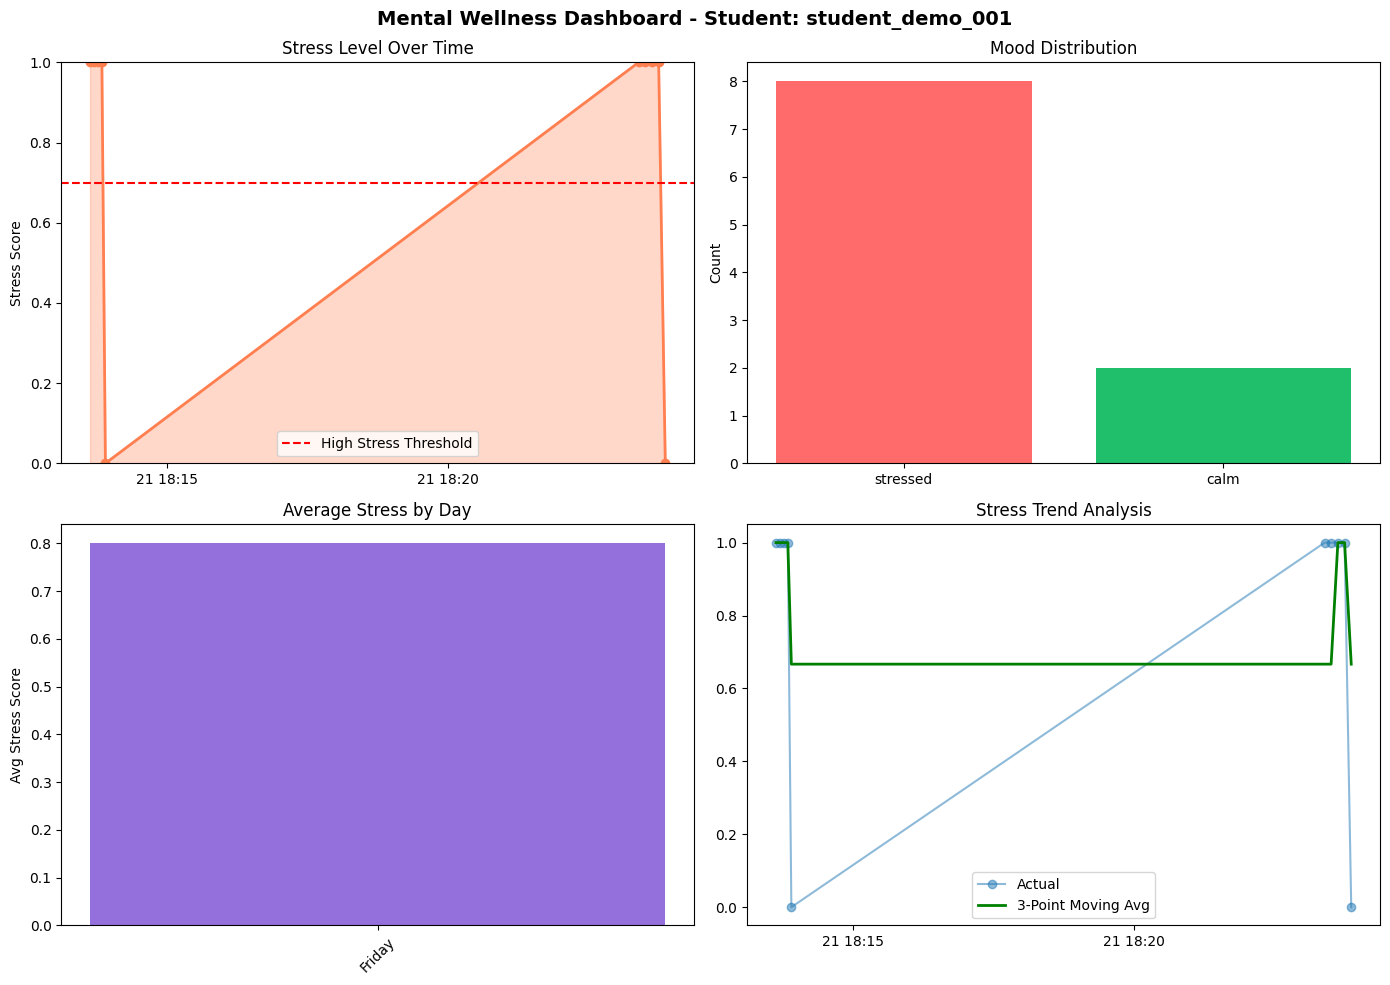

📝 [2025-11-21T18:24:04] [GraphTool] generate_mood_graph

📌 STEP 5: Daily Reflection...
📝 [2025-11-21T18:24:04] [QuizAgent] get_reflection
🤔 Reflection Question: Did you get enough sleep last night?

📌 STEP 6: System Metrics Dashboard...


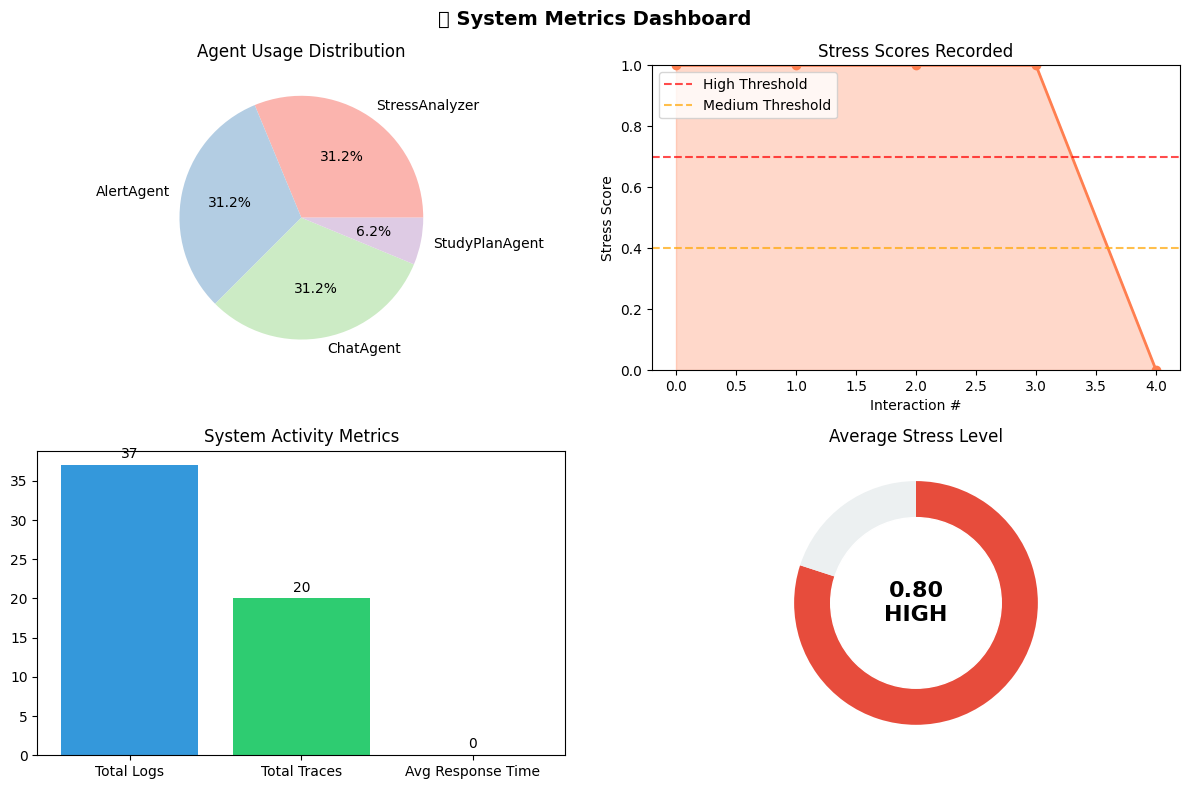


📊 Metrics Summary:
   Total Logs: 37
   Total Traces: 20
   Avg Response Time: 0.000s
   Avg Stress Score: 0.800
   Stress Readings: 5

📌 STEP 7: Conversation Summary...
📝 [2025-11-21T18:24:09] [ChatAgent] summarize_conversation
This conversation highlights an initial struggle with feeling overwhelmed and stressed about falling behind in classes, compounded by guilt over taking necessary breaks. However, it shifts to a more positive note as the user finds relief and a sense of accomplishment after successfully completing an assignment, indicating a move towards building positive momentum.

📌 STEP 8: Ending Session...
📝 [2025-11-21T18:24:12] [ChatAgent] summarize_conversation

📋 SESSION SUMMARY
The user initially expresses feeling overwhelmed and stressed about falling behind, struggling with guilt when taking breaks even though they provide relief. The assistant validates these feelings, reframing breaks as essential, which helps the user acknowledge a recent accomplishment and feel a

In [36]:
# Cell 14: Demo Workflow - Run this to demonstrate the full system

def run_demo():
    """Run a complete demonstration of the AI Wellness Companion"""
    
    print("\n" + "🌟"*25)
    print("   AI MENTAL WELLNESS COMPANION - DEMO")
    print("🌟"*25 + "\n")
    
    # Step 1: Start Session
    print("\n📌 STEP 1: Starting a new session...")
    orchestrator.start_session("student_demo_001")
    
    # Step 2: Simulate conversations
    demo_messages = [
        "Hi, I'm feeling really stressed about my upcoming exams. There's so much to study.",
        "I haven't been sleeping well lately, maybe 4-5 hours per night.",
        "I feel like I'm falling behind in all my classes.",
        "Sometimes I feel a bit better when I take breaks, but then I feel guilty.",
        "Today was actually okay. I managed to finish one assignment."
    ]
    
    print("\n📌 STEP 2: Processing demo conversations...")
    for i, msg in enumerate(demo_messages, 1):
        print(f"\n{'='*60}")
        print(f"💬 USER MESSAGE {i}: \"{msg}\"")
        print(f"{'='*60}")
        
        result = orchestrator.process_message(msg)
        orchestrator.display_response(result)
        time.sleep(1)  # Small delay for readability
    
    # Step 3: Generate Study Plan
    print("\n" + "="*60)
    print("📌 STEP 3: Generating Personalized Study Plan...")
    print("="*60)
    subjects = ["Mathematics", "Physics", "Computer Science"]
    study_plan = orchestrator.get_study_plan(subjects, 4)
    print(study_plan)
    
    # Step 4: Show Wellness Dashboard
    print("\n" + "="*60)
    print("📌 STEP 4: Generating Wellness Dashboard...")
    print("="*60)
    orchestrator.show_dashboard()
    
    # Step 5: Get Reflection Question
    print("\n" + "="*60)
    print("📌 STEP 5: Daily Reflection...")
    print("="*60)
    question = orchestrator.get_reflection_question()
    print(f"🤔 Reflection Question: {question}")
    
    # Step 6: Show Metrics
    print("\n" + "="*60)
    print("📌 STEP 6: System Metrics Dashboard...")
    print("="*60)
    display_metrics_dashboard()
    
    # Step 7: Conversation Summary
    print("\n" + "="*60)
    print("📌 STEP 7: Conversation Summary...")
    print("="*60)
    summary = orchestrator.get_conversation_summary()
    print(summary)
    
    # Step 8: End Session
    print("\n" + "="*60)
    print("📌 STEP 8: Ending Session...")
    print("="*60)
    orchestrator.end_session()
    
    print("\n" + "🎉"*25)
    print("   DEMO COMPLETED SUCCESSFULLY!")
    print("🎉"*25)

# Run the demo
run_demo()

In [37]:
# Cell 15: Run Evaluation Tests

print("\n" + "="*60)
print("🧪 RUNNING SYSTEM EVALUATION")
print("="*60)

# Run comprehensive evaluation
evaluation_report = evaluator.generate_evaluation_report()

# A/B Test
test_messages = [
    "I'm so stressed about everything",
    "Feeling okay today",
    "Can't handle the pressure anymore"
]
ab_results = evaluator.run_ab_test(test_messages)


🧪 RUNNING SYSTEM EVALUATION

📋 COMPREHENSIVE EVALUATION REPORT

🧪 RUNNING STRESS PREDICTION TESTS
📝 [2025-11-21T18:24:29] [StressAnalyzer] full_analysis

❌ Text: "I am so overwhelmed with exams, I can't ..."
   Expected: high, Predicted: medium (Score: 0.61)
📝 [2025-11-21T18:24:31] [StressAnalyzer] full_analysis

✅ Text: "Feeling a bit tired but managing okay..."
   Expected: medium, Predicted: medium (Score: 0.45)
📝 [2025-11-21T18:24:33] [StressAnalyzer] full_analysis

✅ Text: "Had a great day! Finished all my assignm..."
   Expected: low, Predicted: low (Score: 0.00)
📝 [2025-11-21T18:24:36] [StressAnalyzer] full_analysis

✅ Text: "I'm extremely anxious about my grades..."
   Expected: high, Predicted: high (Score: 1.00)
📝 [2025-11-21T18:24:38] [StressAnalyzer] full_analysis

✅ Text: "Just relaxing and watching some videos..."
   Expected: low, Predicted: low (Score: 0.00)
📝 [2025-11-21T18:24:40] [StressAnalyzer] full_analysis

✅ Text: "Too much pressure, deadlines everywhere..."
   

In [38]:
# Cell 16: Interactive Chat Mode

def interactive_chat():
    """Run interactive chat session"""
    print("\n" + "="*60)
    print("🤖 INTERACTIVE WELLNESS CHAT")
    print("="*60)
    print("\nCommands:")
    print("  'quit' - End session")
    print("  'plan' - Get study plan")
    print("  'quiz' - Take wellness quiz")
    print("  'dashboard' - Show wellness dashboard")
    print("  'metrics' - Show system metrics")
    print("  'summary' - Get conversation summary")
    print("="*60)
    
    student_id = input("\nEnter your student ID: ").strip() or "student_001"
    orchestrator.start_session(student_id)
    
    while True:
        user_input = input("\n👤 You: ").strip()
        
        if not user_input:
            continue
        
        if user_input.lower() == 'quit':
            orchestrator.end_session()
            break
        elif user_input.lower() == 'plan':
            subjects = input("Enter subjects (comma-separated): ").split(',')
            hours = int(input("Hours available: ") or "3")
            plan = orchestrator.get_study_plan([s.strip() for s in subjects], hours)
            print(f"\n📚 Your Study Plan:\n{plan}")
        elif user_input.lower() == 'quiz':
            orchestrator.run_wellness_check()
        elif user_input.lower() == 'dashboard':
            orchestrator.show_dashboard()
        elif user_input.lower() == 'metrics':
            display_metrics_dashboard()
        elif user_input.lower() == 'summary':
            print(orchestrator.get_conversation_summary())
        else:
            result = orchestrator.process_message(user_input)
            orchestrator.display_response(result)

# Uncomment to run interactive mode:
interactive_chat()
print("✅ Interactive chat function ready!")


🤖 INTERACTIVE WELLNESS CHAT

Commands:
  'quit' - End session
  'plan' - Get study plan
  'quiz' - Take wellness quiz
  'dashboard' - Show wellness dashboard
  'metrics' - Show system metrics
  'summary' - Get conversation summary



Enter your student ID:  Saket Chaudahry


📝 [2025-11-21T18:25:39] [MemoryAgent] create_session

🌟 WELLNESS SESSION STARTED
📋 Session ID: c0e36686
👤 Student: Saket Chaudahry




👤 You:  Hello



────────────────────────────────────────
📨 Processing: "Hello..."
────────────────────────────────────────

🔍 Step 1: Analyzing sentiment and stress...
📝 [2025-11-21T18:26:02] [StressAnalyzer] full_analysis
   → Emotion: happy (42%)
   → Stress: low (0.00)
   → Burnout Risk: LOW

📝 Step 2: Logging mood data...
📝 [2025-11-21T18:26:02] [MemoryAgent] save_mood
📝 [2025-11-21T18:26:02] [MoodLoggingTool] log_mood

🚨 Step 3: Checking alert conditions...
   ✅ No alerts triggered

💡 Step 4: Generating recommendations...
📝 [2025-11-21T18:26:02] [RecommendationTool] get_recommendations

💬 Step 5: Generating response...
📝 [2025-11-21T18:26:06] [ChatAgent] generate_response

🤖 AI WELLNESS COMPANION RESPONSE

Hi there! It's wonderful to hear from you. Given your positive day yesterday and finishing that assignment, it sounds like you're carrying some great energy. I'm curious, what do you think helped make today feel okay, and how can we keep that positive momentum flowing?



👤 You:  I m feeling sad because my exam was bad 



────────────────────────────────────────
📨 Processing: "I m feeling sad because my exam was bad..."
────────────────────────────────────────

🔍 Step 1: Analyzing sentiment and stress...
📝 [2025-11-21T18:26:46] [StressAnalyzer] full_analysis
   → Emotion: sad (63%)
   → Stress: high (1.00)
   → Burnout Risk: HIGH

📝 Step 2: Logging mood data...
📝 [2025-11-21T18:26:46] [MemoryAgent] save_mood
📝 [2025-11-21T18:26:46] [MoodLoggingTool] log_mood

🚨 Step 3: Checking alert conditions...
📝 [2025-11-21T18:26:46] [AlertAgent] STRESS_SPIKE
   ⚠️ STRESS_SPIKE: ⚠️ High stress detected (Score: 1.00). Consider taking a bre...

💡 Step 4: Generating recommendations...
📝 [2025-11-21T18:26:46] [RecommendationTool] get_recommendations

💬 Step 5: Generating response...
📝 [2025-11-21T18:26:49] [ChatAgent] generate_response

🤖 AI WELLNESS COMPANION RESPONSE

I'm truly sorry to hear that your exam didn't go as you hoped, and it's completely understandable to feel sad and disappointed right now. It takes a lo


👤 You:  how i refresh my mind



────────────────────────────────────────
📨 Processing: "how i refresh my mind..."
────────────────────────────────────────

🔍 Step 1: Analyzing sentiment and stress...
📝 [2025-11-21T18:27:48] [StressAnalyzer] full_analysis
   → Emotion: stressed (33%)
   → Stress: medium (0.40)
   → Burnout Risk: LOW

📝 Step 2: Logging mood data...
📝 [2025-11-21T18:27:48] [MemoryAgent] save_mood
📝 [2025-11-21T18:27:48] [MoodLoggingTool] log_mood

🚨 Step 3: Checking alert conditions...
   ✅ No alerts triggered

💡 Step 4: Generating recommendations...
📝 [2025-11-21T18:27:48] [RecommendationTool] get_recommendations

💬 Step 5: Generating response...
📝 [2025-11-21T18:27:51] [ChatAgent] generate_response

🤖 AI WELLNESS COMPANION RESPONSE

It's completely understandable that you're looking for ways to refresh your mind, especially after a tough exam experience. Taking a moment to reset is a really positive step. How about trying a short change of pace, like a quick 5-minute walk outside, or listening to a c


👤 You:  plan
Enter subjects (comma-separated):  Math, Science and English
Hours available:  4


📝 [2025-11-21T18:29:15] [StudyPlanAgent] error
📝 [2025-11-21T18:29:15] [StudyPlanAgent] generate_plan

📚 Your Study Plan:

📚 **PERSONALIZED STUDY PLAN**
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 **Your Status:**
   • Stress Level: MEDIUM
   • Focus Duration: 35 minutes
   • Break Duration: 7 minutes
   • Total Study Time: 4 hours

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

⏰ **SCHEDULE:**

📖 **09:00 - 09:35** | Math
   └─ Focus: 35 min of concentrated study

☕ **09:35 - 09:42** | BREAK
   └─ 🚶 Take a short walk

📖 **09:42 - 10:17** | Science and English
   └─ Focus: 35 min of concentrated study

☕ **10:17 - 10:24** | BREAK
   └─ 🧘 Do stretching exercises

📖 **10:24 - 10:59** | Math
   └─ Focus: 35 min of concentrated study

☕ **10:59 - 11:06** | BREAK
   └─ 💧 Drink water & have a healthy snack

📖 **11:06 - 11:41** | Science and English
   └─ Focus: 35 min of concentrated study

☕ **11:41 - 11:48** | BREAK
   └─ 🎵 Listen to calming music

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 **W


👤 You:  summary


📝 [2025-11-21T18:30:41] [ChatAgent] summarize_conversation
The conversation highlights the user's sudden shift from positive energy to deep sadness and disappointment after a bad exam, coupled with existing high stress. The assistant validates these feelings, emphasizing that one setback doesn't define worth, and then guides the user towards self-kindness and practical strategies like a short walk or calming music to refresh their mind.



👤 You:  quit


📝 [2025-11-21T18:31:10] [ChatAgent] summarize_conversation

📋 SESSION SUMMARY
The conversation quickly shifts from initial positive energy to the user expressing deep sadness and disappointment over a poor exam, compounded by high stress. The assistant validates these difficult emotions, emphasizing that one exam doesn't define their worth, and then guides the user towards practical ways to refresh their mind and practice self-kindness.

✅ Session ended for Saket Chaudahry
✅ Interactive chat function ready! Uncomment the last line to run.
